# NFL Winner Predictions (Current Week)

This notebook pulls near-real-time NFL game data from ESPN's public scoreboard API, builds simple team ratings from season-to-date results, and predicts winners for the most current week of games. No API keys are required.

Approach:
- Fetch current week (season year, week, season type) from ESPN.
- Gather completed games from previous weeks this season to compute basic team ratings using points scored/allowed and net rating.
- Add a small home-field advantage.
- Convert rating differences to a win probability and pick winners.

Note: This is a lightweight baseline model using readily available data. It won’t match betting markets but updates quickly and runs anywhere.


In [76]:
# Dependencies
import sys
import json
from datetime import datetime, timezone
from typing import Dict, List, Any, Optional, Tuple

# Auto-install lightweight deps if missing
try:
    import requests  # type: ignore
    import pandas as pd  # type: ignore
    import numpy as np  # type: ignore
    from sklearn.linear_model import LogisticRegression  # type: ignore
except Exception:
    !{sys.executable} -m pip install --quiet requests pandas numpy scikit-learn
    import requests  # type: ignore
    import pandas as pd  # type: ignore
    import numpy as np  # type: ignore
    from sklearn.linear_model import LogisticRegression  # type: ignore

ESPN_SCOREBOARD_URL = "https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard"
HOME_FIELD_ADVANTAGE_POINTS = 1.5  # simple constant
LOGISTIC_SCALE = 7.0  # larger => flatter probability curve

# Prediction behavior flags
USE_ML_MODEL = True          # train a simple logistic regression on prior weeks
USE_MARKET_ODDS = True       # blend with moneyline-implied probability when available
BLEND_WEIGHT = 0.10          # 0.0=model only, 1.0=market only where available
USE_SOS_ADJUSTED = True      # use strength-of-schedule adjusted ratings (SRS) when available
SRS_ITERATIONS = 10          # iterations for SRS fixed-point solver

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)



In [77]:
def get_json(url: str, params: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    return response.json()


def get_current_week_info() -> Dict[str, Any]:
    data = get_json(ESPN_SCOREBOARD_URL)
    # Fallback handling if keys vary
    season = data.get("season", {})
    week = data.get("week", {})
    # ESPN uses seasonType: 1=Pre, 2=Reg, 3=Post
    info = {
        "season_year": season.get("year"),
        "season_type": season.get("type"),
        "week": week.get("number"),
        "raw": data,
    }
    return info


def fetch_week_scoreboard(season_year: int, season_type: int, week: int) -> Dict[str, Any]:
    params = {"year": season_year, "seasontype": season_type, "week": week}
    return get_json(ESPN_SCOREBOARD_URL, params=params)


def parse_games_from_scoreboard(board: Dict[str, Any]) -> pd.DataFrame:
    events: List[Dict[str, Any]] = board.get("events", [])
    rows: List[Dict[str, Any]] = []

    for ev in events:
        competitions = ev.get("competitions", [])
        if not competitions:
            continue
        comp = competitions[0]
        competitors = comp.get("competitors", [])
        if len(competitors) != 2:
            continue

        # Normalize home/away
        home = next((c for c in competitors if c.get("homeAway") == "home"), None)
        away = next((c for c in competitors if c.get("homeAway") == "away"), None)
        if home is None or away is None:
            continue

        def team_key(c: Dict[str, Any]) -> Tuple[str, str]:
            t = c.get("team", {})
            return t.get("id", ""), t.get("abbreviation", "")

        home_id, home_abbr = team_key(home)
        away_id, away_abbr = team_key(away)

        # Scores may be absent for future games
        try:
            home_score = float(home.get("score")) if home.get("score") is not None else None
        except Exception:
            home_score = None
        try:
            away_score = float(away.get("score")) if away.get("score") is not None else None
        except Exception:
            away_score = None

        status = ev.get("status", {}).get("type", {})
        status_desc = status.get("description")
        status_state = status.get("state")  # pre, in, post

        start_time_iso = ev.get("date")
        try:
            start_dt = datetime.fromisoformat(start_time_iso.replace("Z", "+00:00")) if start_time_iso else None
        except Exception:
            start_dt = None

        rows.append({
            "event_id": ev.get("id"),
            "season_year": board.get("season", {}).get("year"),
            "season_type": board.get("season", {}).get("type"),
            "week": board.get("week", {}).get("number"),
            "home_id": home_id,
            "home": home_abbr,
            "away_id": away_id,
            "away": away_abbr,
            "home_score": home_score,
            "away_score": away_score,
            "status_state": status_state,
            "status_desc": status_desc,
            "start_time": start_dt,
        })

    return pd.DataFrame(rows)


print("Fetchers ready.")


Fetchers ready.


In [78]:
def build_season_results_until_week(season_year: int, season_type: int, up_to_week_exclusive: int) -> pd.DataFrame:
    all_weeks: List[pd.DataFrame] = []
    for w in range(1, up_to_week_exclusive):
        try:
            board = fetch_week_scoreboard(season_year, season_type, w)
            df = parse_games_from_scoreboard(board)
            if not df.empty:
                # Keep only completed games for stats
                done = df[df["status_state"].isin(["post"])].copy()
                if not done.empty:
                    all_weeks.append(done)
        except Exception as e:
            print(f"Warning: failed to load week {w}: {e}")
            continue
    if not all_weeks:
        return pd.DataFrame(columns=[
            "team", "games", "points_for", "points_against", "ppg", "papg", "net_rating", "srs_rating"
        ])

    games = pd.concat(all_weeks, ignore_index=True)

    # Build team-level aggregates
    home_stats = games[["home", "home_score", "away_score"]].rename(columns={
        "home": "team",
        "home_score": "points_for",
        "away_score": "points_against",
    })
    away_stats = games[["away", "away_score", "home_score"]].rename(columns={
        "away": "team",
        "away_score": "points_for",
        "home_score": "points_against",
    })

    tall = pd.concat([home_stats, away_stats], ignore_index=True)
    agg = tall.groupby("team", as_index=False).agg(
        games=("points_for", "count"),
        points_for=("points_for", "sum"),
        points_against=("points_against", "sum"),
    )
    agg["ppg"] = agg["points_for"] / agg["games"].clip(lower=1)
    agg["papg"] = agg["points_against"] / agg["games"].clip(lower=1)
    agg["net_rating"] = agg["ppg"] - agg["papg"]

    # Compute SRS (Simple Rating System) using completed games
    try:
        teams = sorted(set(pd.concat([games["home"], games["away"]]).dropna().unique().tolist()))
        ratings = {t: 0.0 for t in teams}
        game_rows: List[Tuple[str, str, float]] = []  # (team, opponent, margin)
        for _, r in games.iterrows():
            if pd.isna(r["home_score"]) or pd.isna(r["away_score"]):
                continue
            margin_home = float(r["home_score"]) - float(r["away_score"])  # from home perspective
            game_rows.append((str(r["home"]), str(r["away"]), margin_home))
            game_rows.append((str(r["away"]), str(r["home"]), -margin_home))
        iters = int(SRS_ITERATIONS) if "SRS_ITERATIONS" in globals() else 10
        for _ in range(max(1, iters)):
            new_ratings: Dict[str, float] = {}
            for t in teams:
                tg = [g for g in game_rows if g[0] == t]
                if not tg:
                    new_ratings[t] = 0.0
                    continue
                new_ratings[t] = sum(m + ratings.get(opp, 0.0) for _, opp, m in tg) / float(len(tg))
            ratings = new_ratings
        # Normalize to zero-mean
        mean_val = sum(ratings.values()) / float(len(ratings)) if ratings else 0.0
        ratings = {k: v - mean_val for k, v in ratings.items()}
        srs_df = pd.DataFrame({"team": list(ratings.keys()), "srs_rating": list(ratings.values())})
        agg = agg.merge(srs_df, on="team", how="left")
    except Exception:
        agg["srs_rating"] = np.nan

    return agg


# Discover current week
current = get_current_week_info()
season_year = int(current["season_year"]) if current.get("season_year") else datetime.now(timezone.utc).year
season_type = int(current["season_type"]) if current.get("season_type") else 2  # default regular
current_week = int(current["week"]) if current.get("week") else 1

print({"season_year": season_year, "season_type": season_type, "current_week": current_week})

# Build ratings through prior week
ratings_df = build_season_results_until_week(season_year, season_type, max(1, current_week))
rating_sort_col = "srs_rating" if ("USE_SOS_ADJUSTED" in globals() and USE_SOS_ADJUSTED and "srs_rating" in ratings_df.columns) else "net_rating"
ratings_df.sort_values(rating_sort_col, ascending=False, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)
ratings_df.head(10)


{'season_year': 2025, 'season_type': 2, 'current_week': 14}


,team,games,points_for,points_against,ppg,papg,net_rating,srs_rating
0,LAR,12,334.0,210.0,27.833333,17.500000,10.333333,12.552762
1,SEA,12,350.0,217.0,29.166667,18.083333,11.083333,11.360607
2,HOU,12,263.0,198.0,21.916667,16.500000,5.416667,8.803375
3,IND,12,357.0,249.0,29.750000,20.750000,9.000000,8.610835
4,KC,12,305.0,232.0,25.416667,19.333333,6.083333,6.812044
5,BUF,12,337.0,259.0,28.083333,21.583333,6.500000,5.463084
6,JAX,12,292.0,253.0,24.333333,21.083333,3.250000,5.078570
7,DET,12,350.0,274.0,29.166667,22.833333,6.333333,4.840872
8,SF,13,307.0,269.0,23.615385,20.692308,2.923077,4.571495
9,DEN,12,284.0,218.0,23.666667,18.166667,5.500000,4.018498


In [79]:
import math

def win_prob_from_diff(rating_diff: float, scale: float = LOGISTIC_SCALE) -> float:
    # Logistic mapping from point differential to win probability
    return 1.0 / (1.0 + math.exp(-rating_diff / max(1e-6, scale)))


def predict_current_week_games(
    season_year: int,
    season_type: int,
    current_week: int,
    ratings: pd.DataFrame,
    use_market_odds: Optional[bool] = None,
    blend_weight: Optional[float] = None,
) -> pd.DataFrame:
    board = fetch_week_scoreboard(season_year, season_type, current_week)
    games = parse_games_from_scoreboard(board)
    if games.empty:
        return pd.DataFrame()

    # Resolve behavior flags
    use_odds = USE_MARKET_ODDS if use_market_odds is None else bool(use_market_odds)
    w = BLEND_WEIGHT if blend_weight is None else float(max(0.0, min(1.0, blend_weight)))

    # Train a simple ML model (logistic regression) on prior completed games
    ml_model: Optional[LogisticRegression] = None
    if 'USE_ML_MODEL' in globals() and USE_ML_MODEL and current_week and current_week > 1:
        X_list: List[List[float]] = []
        y_list: List[int] = []
        for wk in range(1, int(current_week)):
            try:
                ratings_prior = build_season_results_until_week(season_year, season_type, wk)
                board_wk = fetch_week_scoreboard(season_year, season_type, wk)
                df_wk = parse_games_from_scoreboard(board_wk)
                if df_wk.empty:
                    continue
                done = df_wk[df_wk["status_state"].isin(["post"])].copy()
                if done.empty:
                    continue
                rating_col_prior = "srs_rating" if ("USE_SOS_ADJUSTED" in globals() and USE_SOS_ADJUSTED and "srs_rating" in ratings_prior.columns) else "net_rating"
                team_to_rating_prior = ratings_prior.set_index("team")[rating_col_prior].to_dict() if not ratings_prior.empty else {}
                for _, row in done.iterrows():
                    home = row["home"]
                    away = row["away"]
                    hs = row["home_score"]
                    as_ = row["away_score"]
                    if pd.isna(hs) or pd.isna(as_):
                        continue
                    home_r = float(team_to_rating_prior.get(home, 0.0))
                    away_r = float(team_to_rating_prior.get(away, 0.0))
                    x = home_r - away_r  # feature: rating differential
                    y = 1 if float(hs) > float(as_) else 0
                    X_list.append([x])
                    y_list.append(y)
            except Exception:
                continue
        if len(X_list) >= 10:
            ml_model = LogisticRegression(solver="lbfgs")
            ml_model.fit(np.asarray(X_list, dtype=float), np.asarray(y_list, dtype=int))

    # Helpers for odds -> probability
    def moneyline_to_prob(ml: Optional[float]) -> Optional[float]:
        if ml is None or pd.isna(ml):
            return None
        try:
            ml = float(ml)
        except Exception:
            return None
        if ml < 0:
            return (-ml) / ((-ml) + 100.0)
        else:
            return 100.0 / (ml + 100.0)

    def extract_market_probs_from_board(board_obj: Dict[str, Any]) -> Dict[str, float]:
        mapping: Dict[str, float] = {}
        for ev in board_obj.get("events", []):
            ev_id = ev.get("id")
            comps = ev.get("competitions", [])
            if not comps:
                continue
            comp = comps[0]
            odds_list = comp.get("odds", []) or []
            if not odds_list:
                continue
            choice = None
            for o in odds_list:
                provider = (o.get("provider") or {}).get("name", "").lower()
                if "consensus" in provider:
                    choice = o
                    break
            if choice is None:
                choice = odds_list[0]
            home_odds = (choice.get("homeTeamOdds") or {})
            away_odds = (choice.get("awayTeamOdds") or {})
            ml_home = home_odds.get("moneyLine")
            ml_away = away_odds.get("moneyLine")
            ph_raw = moneyline_to_prob(ml_home)
            pa_raw = moneyline_to_prob(ml_away)
            if ph_raw is None or pa_raw is None:
                continue
            s = ph_raw + pa_raw
            if s <= 0:
                continue
            mapping[ev_id] = ph_raw / s
        return mapping

    market_map: Dict[str, float] = extract_market_probs_from_board(board) if use_odds else {}

    # Index ratings by team abbr (use SRS if enabled and present)
    rating_col = "srs_rating" if ("USE_SOS_ADJUSTED" in globals() and USE_SOS_ADJUSTED and "srs_rating" in ratings.columns) else "net_rating"
    team_to_rating = ratings.set_index("team")[rating_col].to_dict() if not ratings.empty else {}

    rows: List[Dict[str, Any]] = []
    for _, g in games.iterrows():
        home = g["home"]
        away = g["away"]
        home_rating = float(team_to_rating.get(home, 0.0))
        away_rating = float(team_to_rating.get(away, 0.0))

        # Home-field advantage added to home team rating for heuristic model
        diff_home_minus_away = (home_rating + HOME_FIELD_ADVANTAGE_POINTS) - away_rating

        # Base model probability (heuristic)
        prob_home_model = win_prob_from_diff(diff_home_minus_away)

        # ML probability if model trained
        prob_home_ml = None
        if ml_model is not None:
            x_cur = np.asarray([[home_rating - away_rating]], dtype=float)
            prob_home_ml = float(ml_model.predict_proba(x_cur)[0][1])

        # Choose model prob: ML when available, else heuristic
        prob_home_base = prob_home_ml if prob_home_ml is not None else prob_home_model

        # Optional market odds blending
        prob_home = prob_home_base
        if use_odds:
            ev_id = g.get("event_id")
            ph_market = market_map.get(ev_id)
            if ph_market is not None and 0.0 <= ph_market <= 1.0:
                prob_home = (1.0 - w) * prob_home_base + w * ph_market
        prob_away = 1.0 - prob_home

        predicted_winner = home if prob_home >= 0.5 else away
        confidence = max(prob_home, prob_away)

        rows.append({
            "season_year": int(g["season_year"]) if pd.notna(g["season_year"]) else season_year,
            "season_type": int(g["season_type"]) if pd.notna(g["season_type"]) else season_type,
            "week": int(g["week"]) if pd.notna(g["week"]) else current_week,
            "kickoff_utc": g["start_time"],
            "away": away,
            "home": home,
            "home_rating": home_rating,
            "away_rating": away_rating,
            "rating_diff_home_minus_away": diff_home_minus_away,
            "prob_home_model": prob_home_model,
            "prob_home_ml": prob_home_ml,
            "prob_home_used": prob_home,
            "predicted_winner": predicted_winner,
            "win_prob_predicted": confidence,
            "status": g["status_state"],
            "status_desc": g["status_desc"],
        })

    pred = pd.DataFrame(rows)
    pred.sort_values(["win_prob_predicted", "kickoff_utc"], ascending=[False, True], inplace=True)
    pred.reset_index(drop=True, inplace=True)
    return pred

predictions_df = predict_current_week_games(season_year, season_type, current_week, ratings_df)
predictions_df


,season_year,season_type,week,kickoff_utc,away,home,home_rating,away_rating,rating_diff_home_minus_away,prob_home_model,prob_home_ml,prob_home_used,predicted_winner,win_prob_predicted,status,status_desc
0,2025,2,14,2025-12-07 18:00:00+00:00,CIN,BUF,5.463084,-8.297742,15.260826,0.898450,0.722257,0.722257,BUF,0.722257,pre,Scheduled
1,2025,2,14,2025-12-07 18:00:00+00:00,NO,TB,1.053789,-7.905735,10.459525,0.816710,0.669521,0.669521,TB,0.669521,pre,Scheduled
2,2025,2,14,2025-12-07 21:25:00+00:00,CHI,GB,3.571630,-3.024370,8.096000,0.760709,0.641784,0.641784,GB,0.641784,pre,Scheduled
3,2025,2,14,2025-12-07 18:00:00+00:00,SEA,ATL,-3.799955,11.360607,-13.660562,0.124389,0.366278,0.366278,SEA,0.633722,pre,Scheduled
4,2025,2,14,2025-12-05 01:15:00+00:00,DAL,DET,4.840872,-0.481699,6.822571,0.726046,0.626422,0.626422,DET,0.626422,post,Final
5,2025,2,14,2025-12-07 21:05:00+00:00,DEN,LV,-10.455109,4.018498,-12.973607,0.135477,0.374608,0.374608,DEN,0.625392,pre,Scheduled
6,2025,2,14,2025-12-07 21:25:00+00:00,LAR,ARI,-0.642939,12.552762,-11.695701,0.158316,0.390301,0.390301,LAR,0.609699,pre,Scheduled
7,2025,2,14,2025-12-07 18:00:00+00:00,PIT,BAL,-0.809050,-1.280344,1.971293,0.569942,0.565775,0.565775,BAL,0.565775,pre,Scheduled
8,2025,2,14,2025-12-07 18:00:00+00:00,TEN,CLE,-8.128712,-8.137864,1.509153,0.553691,0.559862,0.559862,CLE,0.559862,pre,Scheduled
9,2025,2,14,2025-12-07 18:00:00+00:00,WSH,MIN,-5.231356,-4.829676,1.098320,0.539145,0.554591,0.554591,MIN,0.554591,pre,Scheduled


In [80]:
# Save predictions to CSV (optional)
from pathlib import Path

now_str = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")
out_dir = Path("predictions_output")
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / f"nfl_predictions_w{current_week}_{season_year}_{now_str}.csv"
if predictions_df is not None and not predictions_df.empty:
    predictions_df.to_csv(csv_path, index=False)
    print(f"Saved predictions to: {csv_path.resolve()}\n")
else:
    print("No predictions generated (no current week games found).\n")

# Show a compact summary
cols = [
    "week", "kickoff_utc", "away", "home", "home_rating", "away_rating",
    "rating_diff_home_minus_away", "predicted_winner", "win_prob_predicted", "status_desc"
]
summary = predictions_df[cols].copy() if not predictions_df.empty else pd.DataFrame()
summary.head(50)


Saved predictions to: C:\Users\bmg32\OneDrive\Desktop\cs441FinalProj\predictions_output\nfl_predictions_w14_2025_20251205_195758.csv



,week,kickoff_utc,away,home,home_rating,away_rating,rating_diff_home_minus_away,predicted_winner,win_prob_predicted,status_desc
0,14,2025-12-07 18:00:00+00:00,CIN,BUF,5.463084,-8.297742,15.260826,BUF,0.722257,Scheduled
1,14,2025-12-07 18:00:00+00:00,NO,TB,1.053789,-7.905735,10.459525,TB,0.669521,Scheduled
2,14,2025-12-07 21:25:00+00:00,CHI,GB,3.571630,-3.024370,8.096000,GB,0.641784,Scheduled
3,14,2025-12-07 18:00:00+00:00,SEA,ATL,-3.799955,11.360607,-13.660562,SEA,0.633722,Scheduled
4,14,2025-12-05 01:15:00+00:00,DAL,DET,4.840872,-0.481699,6.822571,DET,0.626422,Final
5,14,2025-12-07 21:05:00+00:00,DEN,LV,-10.455109,4.018498,-12.973607,DEN,0.625392,Scheduled
6,14,2025-12-07 21:25:00+00:00,LAR,ARI,-0.642939,12.552762,-11.695701,LAR,0.609699,Scheduled
7,14,2025-12-07 18:00:00+00:00,PIT,BAL,-0.809050,-1.280344,1.971293,BAL,0.565775,Scheduled
8,14,2025-12-07 18:00:00+00:00,TEN,CLE,-8.128712,-8.137864,1.509153,CLE,0.559862,Scheduled
9,14,2025-12-07 18:00:00+00:00,WSH,MIN,-5.231356,-4.829676,1.098320,MIN,0.554591,Scheduled


In [81]:
# Plotting dependencies
import sys

try:
    import matplotlib.pyplot as plt  # type: ignore
    import seaborn as sns  # type: ignore
    import numpy as np  # type: ignore
except Exception:
    !{sys.executable} -m pip install --quiet matplotlib seaborn numpy
    import matplotlib.pyplot as plt  # type: ignore
    import seaborn as sns  # type: ignore
    import numpy as np  # type: ignore

sns.set(style="whitegrid")


In [82]:
def determine_actual_winner(row: pd.Series) -> Optional[str]:
    if pd.isna(row.get("home_score")) or pd.isna(row.get("away_score")):
        return None
    if row["home_score"] > row["away_score"]:
        return row["home"]
    if row["away_score"] > row["home_score"]:
        return row["away"]
    return None  # treat ties/unknown as None


def evaluate_week_predictions(season_year: int, season_type: int, week: int, ratings: pd.DataFrame) -> pd.DataFrame:
    board = fetch_week_scoreboard(season_year, season_type, week)
    games = parse_games_from_scoreboard(board)
    if games.empty:
        return pd.DataFrame()

    # Only completed games for evaluation
    games = games[games["status_state"].isin(["post"])].copy()
    if games.empty:
        return pd.DataFrame()

    rating_col = "srs_rating" if ("USE_SOS_ADJUSTED" in globals() and USE_SOS_ADJUSTED and "srs_rating" in ratings.columns) else "net_rating"
    team_to_rating = ratings.set_index("team")[rating_col].to_dict() if not ratings.empty else {}

    rows: List[Dict[str, Any]] = []
    for _, g in games.iterrows():
        home = g["home"]
        away = g["away"]
        home_rating = float(team_to_rating.get(home, 0.0))
        away_rating = float(team_to_rating.get(away, 0.0))

        diff_home_minus_away = (home_rating + HOME_FIELD_ADVANTAGE_POINTS) - away_rating
        prob_home = win_prob_from_diff(diff_home_minus_away)
        prob_away = 1.0 - prob_home

        predicted_winner = home if prob_home >= 0.5 else away
        actual_winner = determine_actual_winner(g)
        if actual_winner is None:
            continue
        correct = predicted_winner == actual_winner
        y_true_home = 1 if actual_winner == home else 0
        prob_actual = prob_home if y_true_home == 1 else prob_away

        rows.append({
            "season_year": int(g["season_year"]) if pd.notna(g["season_year"]) else season_year,
            "season_type": int(g["season_type"]) if pd.notna(g["season_type"]) else season_type,
            "week": int(g["week"]) if pd.notna(g["week"]) else week,
            "kickoff_utc": g["start_time"],
            "away": away,
            "home": home,
            "home_score": g["home_score"],
            "away_score": g["away_score"],
            "home_rating": home_rating,
            "away_rating": away_rating,
            "prob_home": prob_home,
            "prob_away": prob_away,
            "predicted_winner": predicted_winner,
            "actual_winner": actual_winner,
            "correct": bool(correct),
            "y_true_home": y_true_home,
            "prob_actual": prob_actual,
        })

    return pd.DataFrame(rows)


def backtest_until_week(season_year: int, season_type: int, last_week_inclusive: int) -> pd.DataFrame:
    all_games: List[pd.DataFrame] = []
    for w in range(1, max(0, last_week_inclusive) + 1):
        ratings_prior = build_season_results_until_week(season_year, season_type, w)
        week_eval = evaluate_week_predictions(season_year, season_type, w, ratings_prior)
        if not week_eval.empty:
            all_games.append(week_eval)
    if not all_games:
        return pd.DataFrame(columns=[
            "season_year","season_type","week","kickoff_utc","away","home","home_score","away_score",
            "home_rating","away_rating","prob_home","prob_away","predicted_winner","actual_winner",
            "correct","y_true_home","prob_actual"
        ])
    return pd.concat(all_games, ignore_index=True)

print("Backtest helpers ready.")


Backtest helpers ready.


In [ ]:
# Backtest across past weeks and plot accuracy + calibration
last_week_inclusive = max(1, int(current_week))  # include current week; only completed games are used
backtest_df = backtest_until_week(season_year, season_type, last_week_inclusive)

if backtest_df.empty:
    print("No completed games available yet to evaluate.")
else:
    # Weekly and cumulative accuracy
    wk_counts = backtest_df.groupby("week", as_index=False).agg(
        correct_sum=("correct", "sum"),
        games=("correct", "count"),
        accuracy=("correct", "mean"),
    ).sort_values("week")
    wk_counts["cum_correct"] = wk_counts["correct_sum"].cumsum()
    wk_counts["cum_games"] = wk_counts["games"].cumsum()
    wk_counts["cum_accuracy"] = wk_counts["cum_correct"] / wk_counts["cum_games"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.lineplot(data=wk_counts, x="week", y="accuracy", marker="o", ax=axes[0])
    axes[0].set_title("Weekly accuracy")
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("Accuracy")

    sns.lineplot(data=wk_counts, x="week", y="cum_accuracy", marker="o", ax=axes[1], color="tab:green")
    axes[1].set_title("Cumulative accuracy")
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel("Week")
    axes[1].set_ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

    # Calibration (reliability) plot using probability assigned to actual outcome
    backtest_df["prob_actual"] = np.where(backtest_df["y_true_home"] == 1, backtest_df["prob_home"], backtest_df["prob_away"])
    bins = np.linspace(0.0, 1.0, 11)
    backtest_df["prob_bin"] = pd.cut(backtest_df["prob_actual"], bins=bins, include_lowest=True)
    calib = backtest_df.groupby("prob_bin", as_index=False).agg(
        mean_pred=("prob_actual", "mean"),
        empirical=("correct", "mean"),
        n=("correct", "count"),
    ).dropna()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="perfect")
    sns.scatterplot(data=calib, x="mean_pred", y="empirical", size="n", sizes=(20, 200), ax=ax)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Predicted probability (actual outcome)")
    ax.set_ylabel("Observed frequency")
    ax.set_title("Calibration (reliability)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Brier score using home-win probability as the forecast
    y_true = backtest_df["y_true_home"].values.astype(float)
    brier = np.mean((backtest_df["prob_home"].values - y_true) ** 2)
    print(f"Brier score (home win prob): {brier:.3f}")

    # Display summary tables
    display(wk_counts)
    backtest_df.sort_values(["week", "kickoff_utc"]).head(20)


In [75]:
# Predict any chosen week (past/current/future) and optionally evaluate a past week
# Adjust the parameters below, then run this cell.

# --- Prediction parameters ---
target_season_year = season_year   # e.g., 2025
target_season_type = season_type   # 1=Pre, 2=Reg, 3=Post
target_week = 14         # e.g., 14 (set any week)

# Build ratings from games BEFORE the target week
ratings_for_target = build_season_results_until_week(
    int(target_season_year), int(target_season_type), int(target_week)
)

# Predict the chosen week
pred_for_target = predict_current_week_games(
    int(target_season_year), int(target_season_type), int(target_week), ratings_for_target
)

# Show results
pred_cols = [
    "week", "kickoff_utc", "away", "home",
    "home_rating", "away_rating", "rating_diff_home_minus_away",
    "predicted_winner", "win_prob_predicted", "status_desc"
]
if pred_for_target is not None and not pred_for_target.empty:
    display(pred_for_target[pred_cols].sort_values(["kickoff_utc"]))
else:
    print("No games returned for the chosen week (schedule may not be published yet).")

# --- Optional: evaluate a completed past week ---
eval_season_year = target_season_year
eval_season_type = target_season_type
# Set to a completed week to evaluate, or None to skip
maybe_eval_week = None  # e.g., 13

if maybe_eval_week is not None:
    ratings_prior = build_season_results_until_week(
        int(eval_season_year), int(eval_season_type), int(maybe_eval_week)
    )
    week_eval = evaluate_week_predictions(
        int(eval_season_year), int(eval_season_type), int(maybe_eval_week), ratings_prior
    )
    if not week_eval.empty:
        acc = week_eval["correct"].mean()
        print(f"Week {maybe_eval_week} accuracy: {acc:.3f} (n={len(week_eval)})")
        display(
            week_eval[[
                "week", "kickoff_utc", "away", "home", "home_score", "away_score",
                "predicted_winner", "actual_winner", "correct", "prob_home", "prob_away"
            ]].sort_values(["kickoff_utc"]) 
        )
    else:
        print("No completed games found to evaluate for that week.")


,week,kickoff_utc,away,home,home_rating,away_rating,rating_diff_home_minus_away,predicted_winner,win_prob_predicted,status_desc
6,14,2025-12-05 01:15:00+00:00,DAL,DET,6.333333,0.750000,8.583333,DET,0.652542,Final
0,14,2025-12-07 18:00:00+00:00,CIN,BUF,6.500000,-7.833333,17.333333,BUF,0.770236,Scheduled
2,14,2025-12-07 18:00:00+00:00,NO,TB,-1.833333,-9.416667,10.583333,TB,0.681933,Scheduled
3,14,2025-12-07 18:00:00+00:00,TEN,CLE,-6.333333,-13.166667,9.833333,CLE,0.671065,Scheduled
4,14,2025-12-07 18:00:00+00:00,SEA,ATL,-2.750000,11.083333,-10.833333,SEA,0.658252,Scheduled
9,14,2025-12-07 18:00:00+00:00,WSH,MIN,-4.750000,-5.083333,3.333333,MIN,0.570180,Scheduled
10,14,2025-12-07 18:00:00+00:00,PIT,BAL,-0.333333,-0.666667,3.333333,BAL,0.570180,Scheduled
12,14,2025-12-07 18:00:00+00:00,IND,JAX,3.250000,9.000000,-2.750000,IND,0.530025,Scheduled
13,14,2025-12-07 18:00:00+00:00,MIA,NYJ,-5.750000,-3.250000,0.500000,NYJ,0.523724,Scheduled
1,14,2025-12-07 21:05:00+00:00,DEN,LV,-10.750000,5.500000,-13.250000,DEN,0.693289,Scheduled


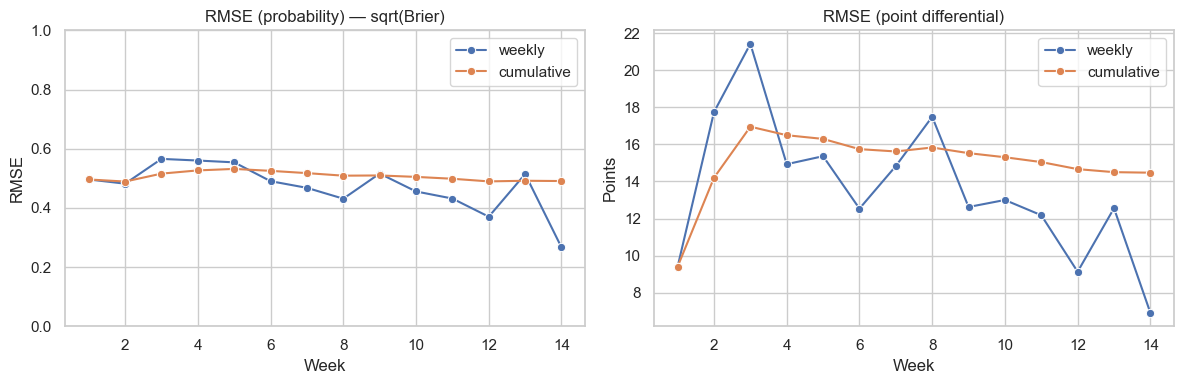

,week,games,accuracy,cum_accuracy,rmse_prob,cum_rmse_prob,rmse_diff_points,cum_rmse_diff_points
0,1,16,0.562500,0.562500,0.496162,0.496162,9.407444,9.407444
1,2,16,0.687500,0.625000,0.481936,0.489101,17.744718,14.201672
2,3,16,0.562500,0.604167,0.565723,0.515908,21.421368,16.953367
3,4,15,0.466667,0.571429,0.560139,0.526776,14.931386,16.494441
4,5,14,0.571429,0.571429,0.554002,0.531830,15.362873,16.294547
5,6,15,0.666667,0.586957,0.490369,0.525293,12.535736,15.743050
6,7,15,0.733333,0.607477,0.467817,0.517621,14.830774,15.618373
7,8,13,0.769231,0.625000,0.431193,0.508967,17.489188,15.831726
8,9,14,0.500000,0.611940,0.516136,0.509721,12.623124,15.527547
9,10,14,0.714286,0.621622,0.455614,0.504851,13.001218,15.306436


In [ ]:
# RMSE metrics: probability (sqrt of Brier) and point-differential
# Uses backtest_df created earlier (completed games only)

if 'backtest_df' not in globals() or backtest_df is None or backtest_df.empty:
    print("Run the backtest cell first; no completed games to evaluate.")
else:
    df = backtest_df.copy()

    # Predicted probability error (home win probability vs actual outcome)
    # RMSE_prob = sqrt(mean((prob_home - y_true_home)^2))
    df["prob_sq_error"] = (df["prob_home"] - df["y_true_home"].astype(float)) ** 2

    # Predicted point differential vs actual final margin
    # Our implied point prediction is (home_rating + HFA - away_rating)
    df["pred_point_diff"] = (df["home_rating"] + HOME_FIELD_ADVANTAGE_POINTS) - df["away_rating"]
    df["actual_point_diff"] = (df["home_score"] - df["away_score"]).astype(float)
    df["diff_sq_error"] = (df["pred_point_diff"] - df["actual_point_diff"]) ** 2

    # Weekly RMSE and accuracy
    wk_rmse = df.groupby("week", as_index=False).agg(
        games=("correct", "count"),
        correct_sum=("correct", "sum"),
        brier=("prob_sq_error", "mean"),
        diff_mse=("diff_sq_error", "mean"),
        sum_prob_sq=("prob_sq_error", "sum"),
        sum_diff_sq=("diff_sq_error", "sum"),
    ).sort_values("week")
    wk_rmse["rmse_prob"] = (wk_rmse["brier"]) ** 0.5
    wk_rmse["rmse_diff_points"] = (wk_rmse["diff_mse"]) ** 0.5
    wk_rmse["accuracy"] = wk_rmse["correct_sum"] / wk_rmse["games"].clip(lower=1)

    # Cumulative metrics across weeks (progressively)
    wk_rmse["cum_games"] = wk_rmse["games"].cumsum()
    wk_rmse["cum_correct"] = wk_rmse["correct_sum"].cumsum()
    wk_rmse["cum_accuracy"] = wk_rmse["cum_correct"] / wk_rmse["cum_games"].clip(lower=1)
    wk_rmse["cum_prob_sq"] = wk_rmse["sum_prob_sq"].cumsum()
    wk_rmse["cum_diff_sq"] = wk_rmse["sum_diff_sq"].cumsum()
    wk_rmse["cum_rmse_prob"] = (wk_rmse["cum_prob_sq"] / wk_rmse["cum_games"]).pow(0.5)
    wk_rmse["cum_rmse_diff_points"] = (wk_rmse["cum_diff_sq"] / wk_rmse["cum_games"]).pow(0.5)

    # Plot weekly and cumulative RMSE
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.lineplot(data=wk_rmse, x="week", y="rmse_prob", marker="o", ax=axes[0], label="weekly")
    sns.lineplot(data=wk_rmse, x="week", y="cum_rmse_prob", marker="o", ax=axes[0], label="cumulative")
    axes[0].set_title("RMSE (probability) — sqrt(Brier)")
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("RMSE")
    axes[0].set_ylim(0, 1)

    sns.lineplot(data=wk_rmse, x="week", y="rmse_diff_points", marker="o", ax=axes[1], label="weekly")
    sns.lineplot(data=wk_rmse, x="week", y="cum_rmse_diff_points", marker="o", ax=axes[1], label="cumulative")
    axes[1].set_title("RMSE (point differential)")
    axes[1].set_xlabel("Week")
    axes[1].set_ylabel("Points")
    plt.tight_layout()
    plt.show()

    # Show table with accuracy columns
    display(wk_rmse[[
        "week", "games", "accuracy", "cum_accuracy", "rmse_prob", "cum_rmse_prob", "rmse_diff_points", "cum_rmse_diff_points"
    ]])


In [ ]:
# Tune HFA and logistic scale using existing backtest_df (no refetch needed)
# Searches for parameters minimizing mean Brier score (probability MSE)

if 'backtest_df' not in globals() or backtest_df is None or backtest_df.empty:
    print("Run the backtest cell first to create backtest_df.")
else:
    cand_hfa = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
    cand_scale = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

    def brier_for_params(hfa: float, scale: float) -> float:
        ph = 1.0 / (1.0 + np.exp(-(((backtest_df["home_rating"] + hfa) - backtest_df["away_rating"]) / max(1e-6, scale))))
        y = backtest_df["y_true_home"].astype(float)
        return float(np.mean((ph - y) ** 2))

    best = None
    best_brier = float("inf")
    for h in cand_hfa:
        for s in cand_scale:
            b = brier_for_params(h, s)
            if b < best_brier:
                best_brier = b
                best = (h, s)

    if best is not None:
        HOME_FIELD_ADVANTAGE_POINTS = float(best[0])
        LOGISTIC_SCALE = float(best[1])
        print(f"Tuned parameters -> HFA: {HOME_FIELD_ADVANTAGE_POINTS:.2f}, Scale: {LOGISTIC_SCALE:.2f}, Brier: {best_brier:.4f}")
        print("Re-run prediction cells to use the tuned parameters.")
    else:
        print("No tuning result computed.")


Tuned parameters -> HFA: 3.00, Scale: 10.00, Brier: 0.2304
Re-run prediction cells to use the tuned parameters.
